In [1]:
# ! pip install ipynb
from ipynb.fs.full.my_functions import *
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns; sns.set()

In [2]:
ilc = pd.read_csv(r'C:\Users\dvale\TFM\Data\ilc.csv', low_memory=False)

In [3]:
unflaged_columns = unflag(ilc.columns)
ilc = ilc[unflaged_columns]

In [4]:
ilc = ilc.drop(irrelevant_columns, axis=1)

In [5]:
sociodemo = pd.DataFrame({'id': ilc['Personal ID'], 
                          'weight': ilc['Personal cross-sectional weight'], 
                          'material_deprivation': ilc['Household endures severe material deprivation']})

sociodemo['sex'] = ilc['Sex']
sociodemo.head()

,id,weight,material_deprivation,sex
0,101,906.15830,No,Male
1,102,906.15830,No,Female
2,201,1227.68869,No,Female
3,202,1227.68869,No,Male
4,301,2559.35987,No,Female


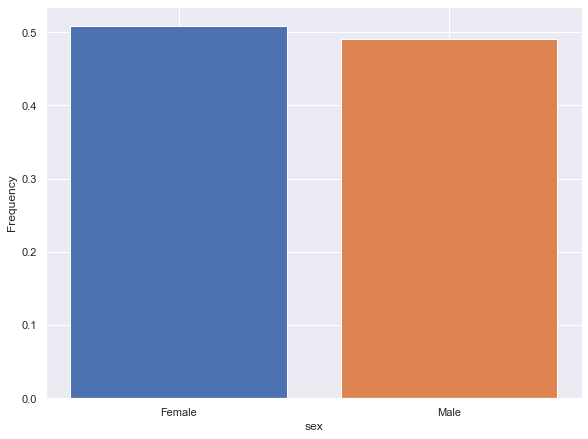

In [6]:
barplot(x='sex', data=sociodemo)

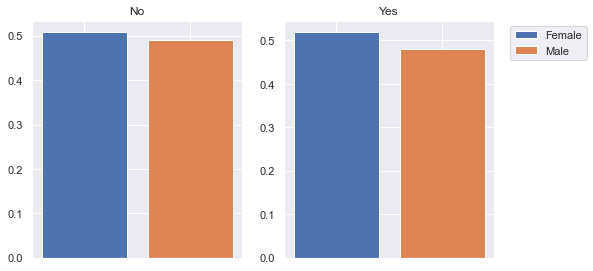

In [7]:
bardiagram(x='material_deprivation', hue='sex', data=sociodemo, legend=True)

In [8]:
sociodemo['age'] = ilc['Year of birth'].apply(lambda x: 2019-x)
sociodemo.head()

,id,weight,material_deprivation,sex,age
0,101,906.15830,No,Male,70
1,102,906.15830,No,Female,68
2,201,1227.68869,No,Female,72
3,202,1227.68869,No,Male,60
4,301,2559.35987,No,Female,54


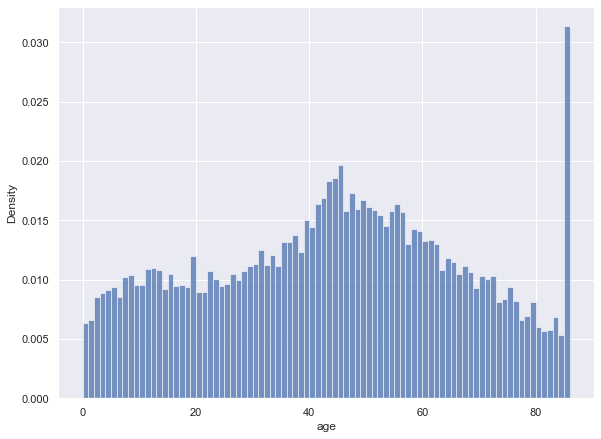

In [9]:
histplot(x='age', data=sociodemo, bins=86)

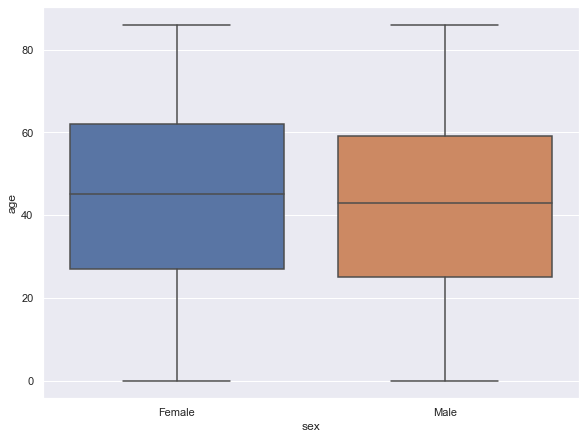

In [10]:
boxplot(x='sex', y='age', data=sociodemo)

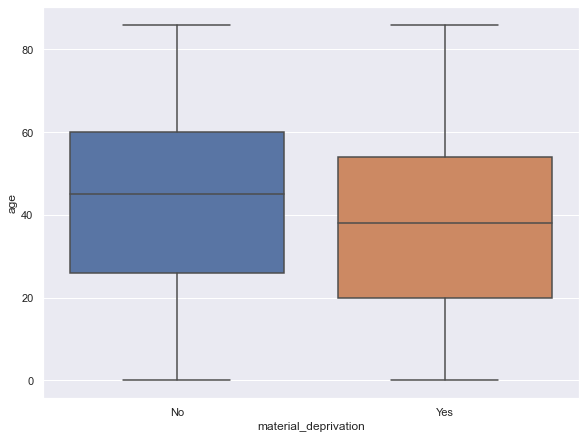

In [11]:
boxplot(x='material_deprivation', y='age', data=sociodemo)

In [12]:
sociodemo['civil_status'] = ilc['Marital status']
sociodemo.civil_status = sociodemo.civil_status.fillna('Missing')
sociodemo.head()

,id,weight,material_deprivation,sex,age,civil_status
0,101,906.15830,No,Male,70,Married
1,102,906.15830,No,Female,68,Married
2,201,1227.68869,No,Female,72,Married
3,202,1227.68869,No,Male,60,Married
4,301,2559.35987,No,Female,54,Divorced


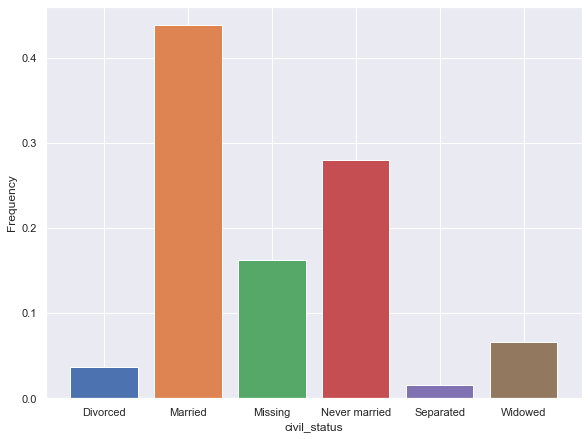

In [13]:
barplot(x='civil_status', data=sociodemo)

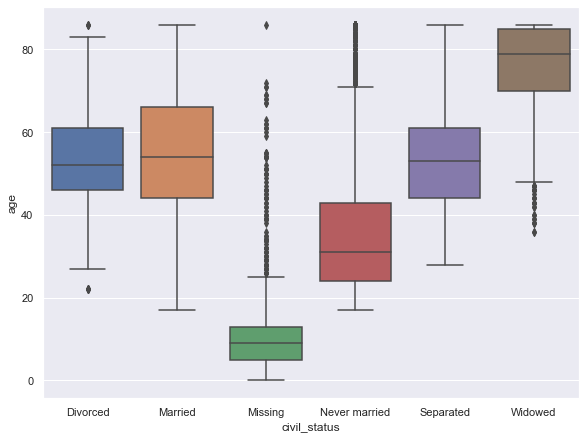

In [14]:
boxplot(x='civil_status', y='age', data=sociodemo)

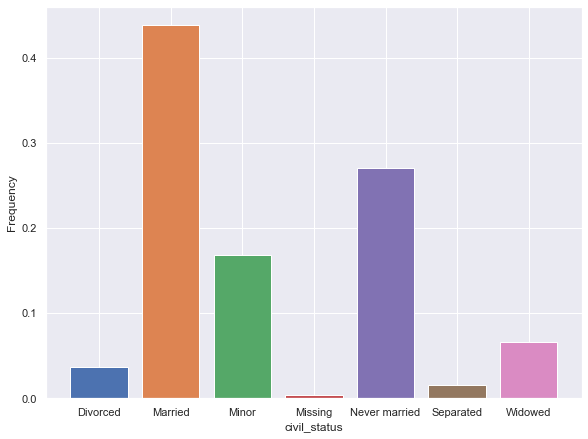

In [15]:
sociodemo['civil_status'] = sociodemo.apply(lambda row: "Minor" 
                                            if row['age'] < 18 
                                            else row['civil_status'],
                                            axis=1)

barplot(x='civil_status', data=sociodemo)

In [16]:
sociodemo['consensual_union'] = ilc['Consensual Union']
sociodemo.consensual_union = sociodemo.consensual_union.fillna('Missing')
sociodemo.head()

,id,weight,material_deprivation,sex,age,civil_status,consensual_union
0,101,906.15830,No,Male,70,Married,"Yes, with legal basis"
1,102,906.15830,No,Female,68,Married,"Yes, with legal basis"
2,201,1227.68869,No,Female,72,Married,"Yes, with legal basis"
3,202,1227.68869,No,Male,60,Married,"Yes, with legal basis"
4,301,2559.35987,No,Female,54,Divorced,No


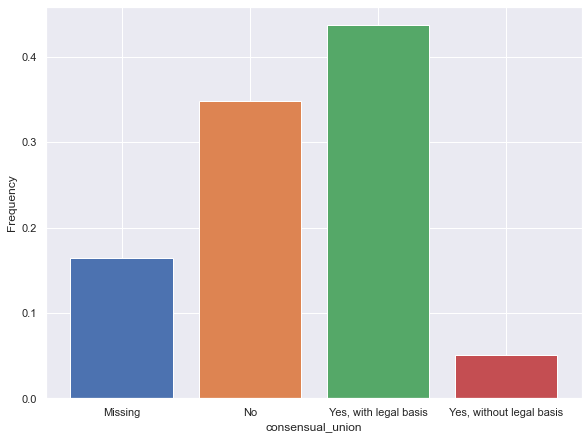

In [17]:
barplot(x='consensual_union', data=sociodemo)

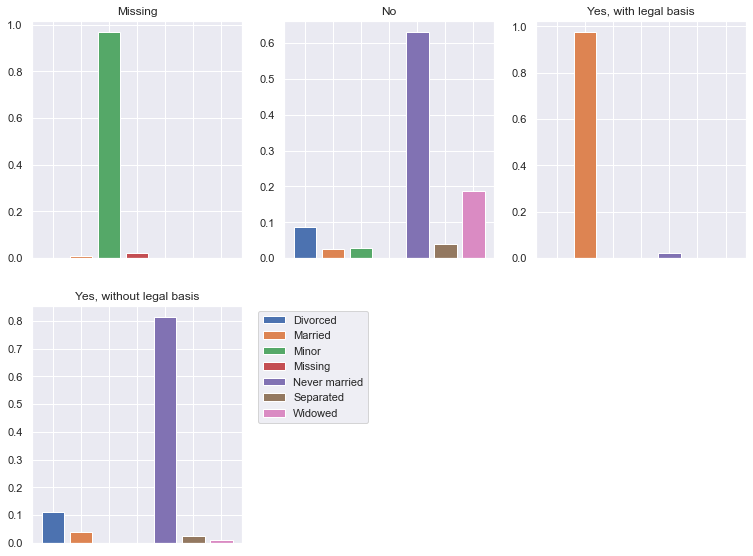

In [18]:
bardiagram(x='consensual_union', hue='civil_status', data=sociodemo, legend=True)

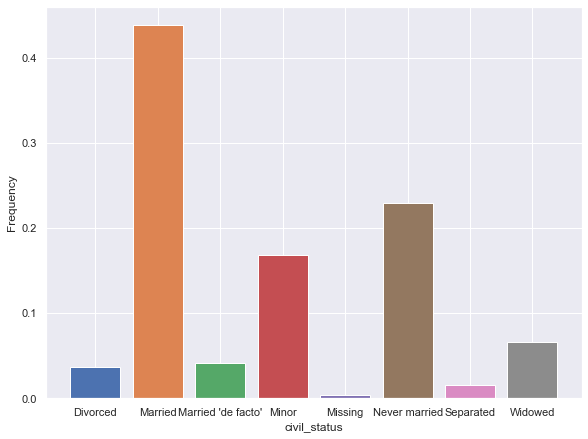

In [19]:
sociodemo['civil_status'] = sociodemo.apply(lambda row: "Married 'de facto'" 
                                            if row['consensual_union'] == 'Yes, without legal basis' 
                                            and row['civil_status'] == 'Never married'
                                            else row['civil_status'],
                                            axis=1)

barplot(x='civil_status', data=sociodemo)

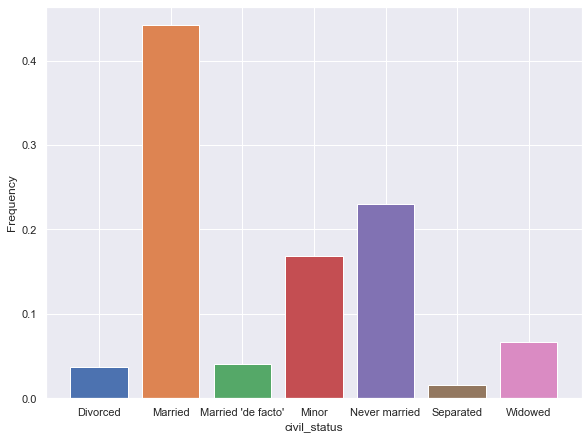

In [20]:
sociodemo['civil_status'] = sociodemo.apply(lambda row: sociodemo.civil_status.mode()[0] 
                                            if row['civil_status'] == 'Missing'
                                            else row['civil_status'],
                                            axis=1)

barplot(x='civil_status', data=sociodemo)

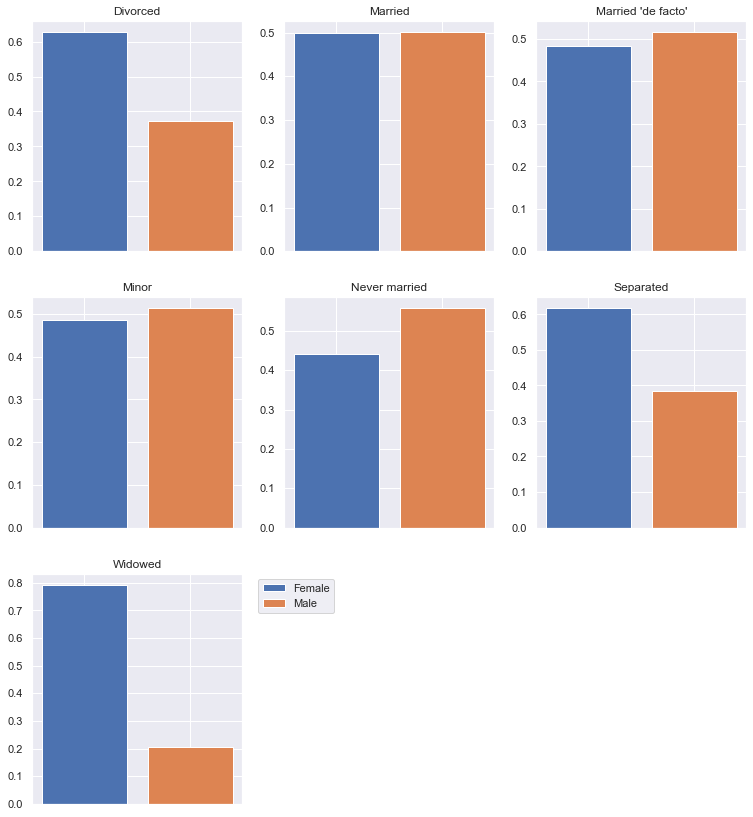

In [21]:
bardiagram(x='civil_status', hue='sex', data=sociodemo, legend=True)

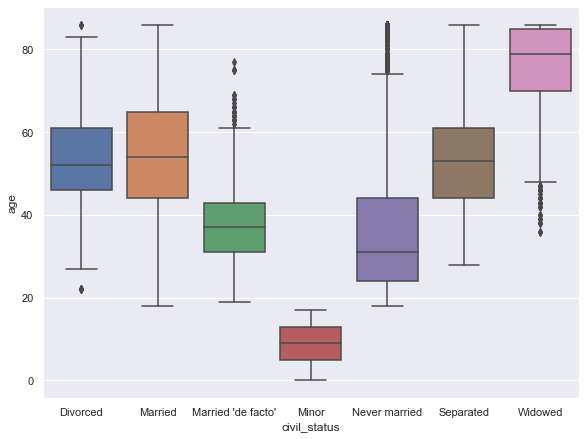

In [22]:
boxplot(x='civil_status', y='age', data=sociodemo)

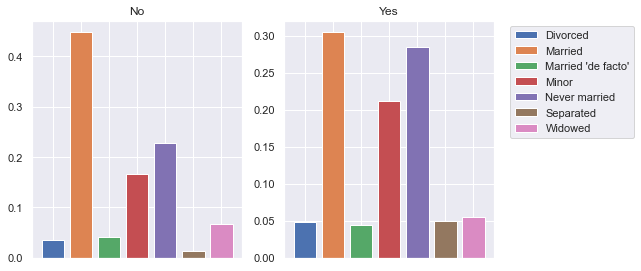

In [23]:
bardiagram(x='material_deprivation', hue='civil_status', data=sociodemo, legend=True)

In [24]:
sociodemo['familial_status'] = ilc['Type of household']

mapped_familial_status = {'Two adults, no children, one older than 64': 'No', 
                          'Two adults with one children': 'Yes', 
                          'One adult with one or more children': 'Yes',
                          'Other household types with no children': 'No',
                          'One female, between 30 and 64': 'No', 
                          'Two adults with two children': 'Yes',
                          'Two adults, no children, both older than 64': 'No',
                          'One male, between 30 and 64': 'No',
                          'Two adults with three or more children': 'Yes',
                          'One male, older than 64': 'No',
                          'One female, older than 64': 'No', 
                          'Other household types with children': 'Yes', 
                          'One male, younger than 30': 'No', 
                          'One female, younger than 30': 'No'}

sociodemo.familial_status = sociodemo.familial_status.map(mapped_familial_status)

sociodemo.familial_status = sociodemo.familial_status.fillna('Missing')
sociodemo.head()

,id,weight,material_deprivation,sex,age,civil_status,consensual_union,familial_status
0,101,906.15830,No,Male,70,Married,"Yes, with legal basis",No
1,102,906.15830,No,Female,68,Married,"Yes, with legal basis",No
2,201,1227.68869,No,Female,72,Married,"Yes, with legal basis",No
3,202,1227.68869,No,Male,60,Married,"Yes, with legal basis",No
4,301,2559.35987,No,Female,54,Divorced,No,Yes


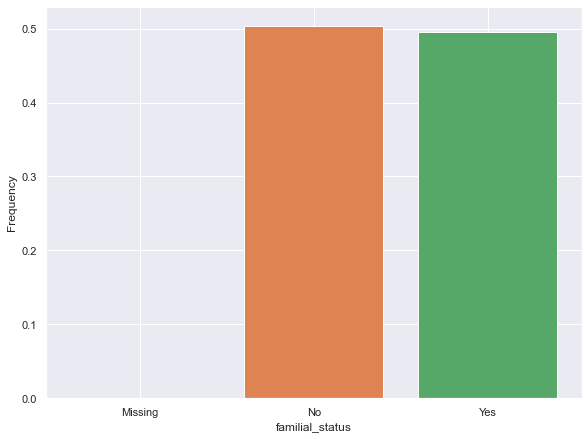

In [25]:
barplot(x='familial_status', data=sociodemo)

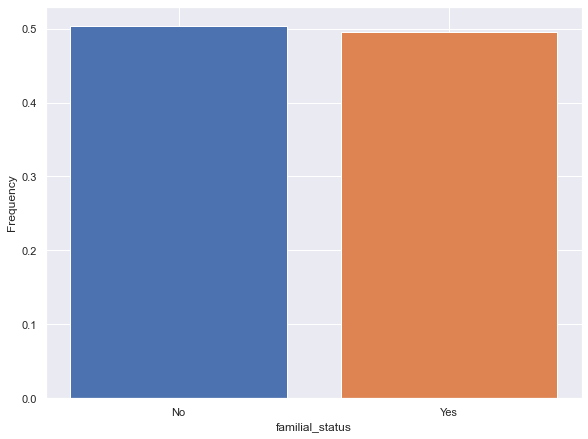

In [26]:
sociodemo['familial_status'] = sociodemo.apply(lambda row: sociodemo.familial_status.mode()[0] 
                                               if row['familial_status'] == 'Missing'
                                               else row['familial_status'],
                                               axis=1)

barplot(x='familial_status', data=sociodemo)

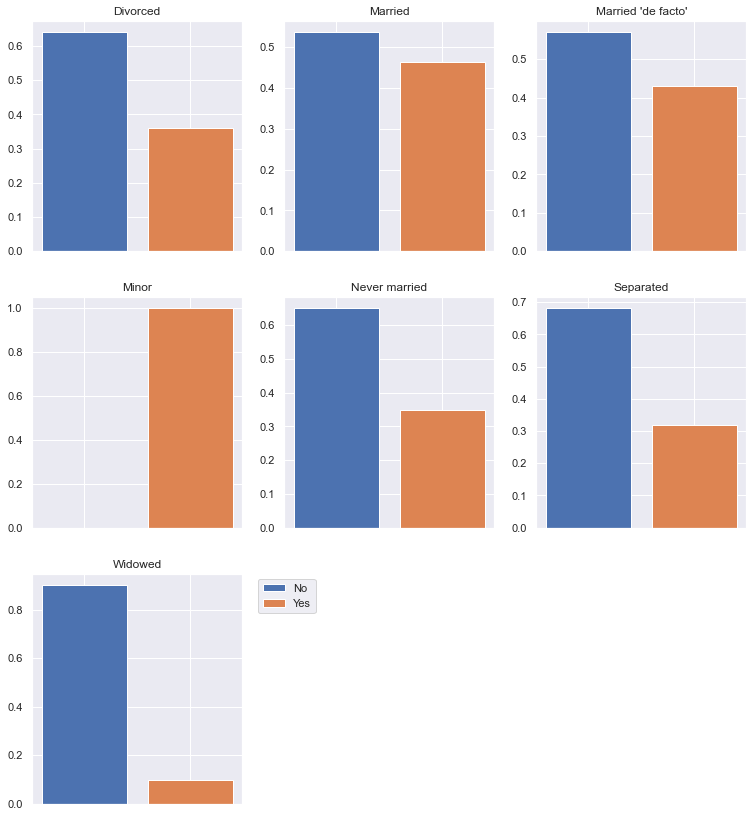

In [27]:
bardiagram(x='civil_status', hue='familial_status', data=sociodemo, legend=True)

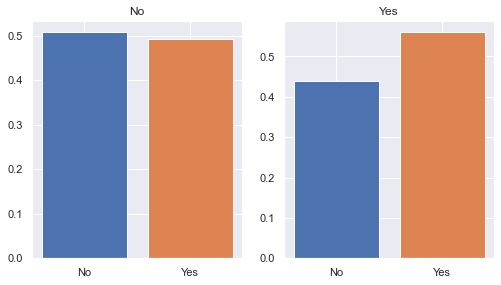

In [28]:
bardiagram(x='material_deprivation', hue='familial_status', data=sociodemo)

In [29]:
sociodemo['region'] = ilc['Region']
sociodemo.head()

,id,weight,material_deprivation,sex,age,civil_status,consensual_union,familial_status,region
0,101,906.15830,No,Male,70,Married,"Yes, with legal basis",No,Basque Country
1,102,906.15830,No,Female,68,Married,"Yes, with legal basis",No,Basque Country
2,201,1227.68869,No,Female,72,Married,"Yes, with legal basis",No,Basque Country
3,202,1227.68869,No,Male,60,Married,"Yes, with legal basis",No,Basque Country
4,301,2559.35987,No,Female,54,Divorced,No,Yes,Basque Country


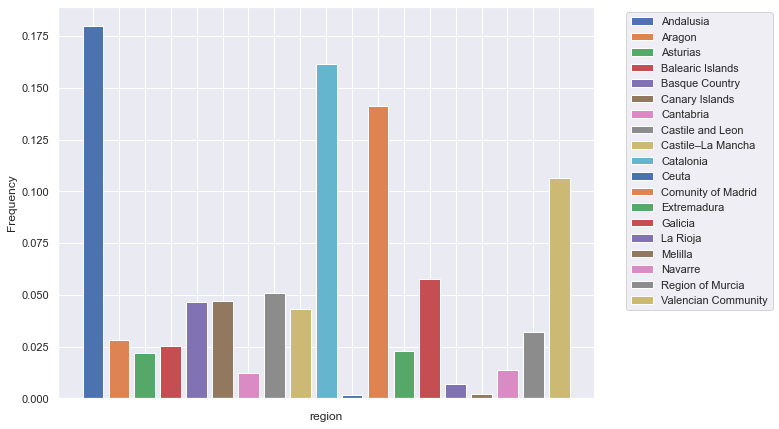

In [30]:
barplot(x='region', data=sociodemo, legend=True)

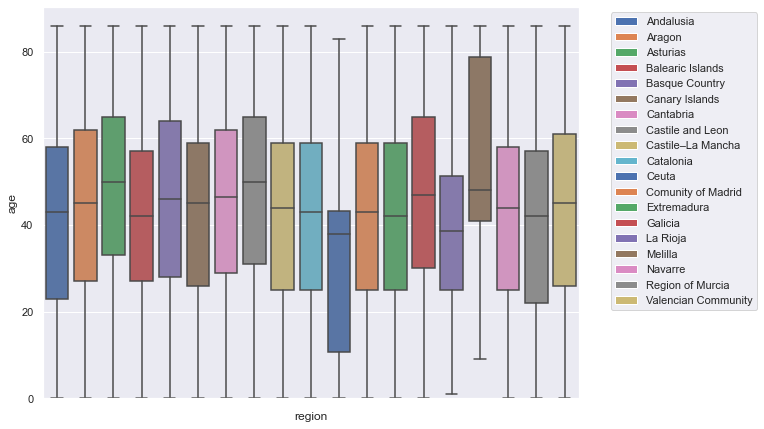

In [31]:
boxplot(x='region', y='age', data=sociodemo, legend=True)

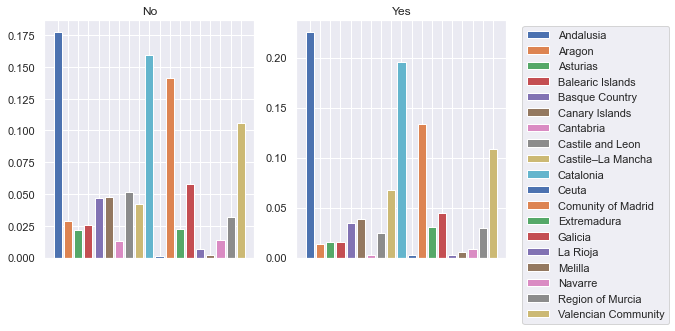

In [32]:
bardiagram(x='material_deprivation', hue='region', data=sociodemo, legend=True)

In [33]:
sociodemo['population_density'] = ilc['Degree of urbanisation']

sociodemo.head()

,id,weight,material_deprivation,sex,age,civil_status,consensual_union,familial_status,region,population_density
0,101,906.15830,No,Male,70,Married,"Yes, with legal basis",No,Basque Country,Thinly-populated area
1,102,906.15830,No,Female,68,Married,"Yes, with legal basis",No,Basque Country,Thinly-populated area
2,201,1227.68869,No,Female,72,Married,"Yes, with legal basis",No,Basque Country,Thinly-populated area
3,202,1227.68869,No,Male,60,Married,"Yes, with legal basis",No,Basque Country,Thinly-populated area
4,301,2559.35987,No,Female,54,Divorced,No,Yes,Basque Country,Thinly-populated area


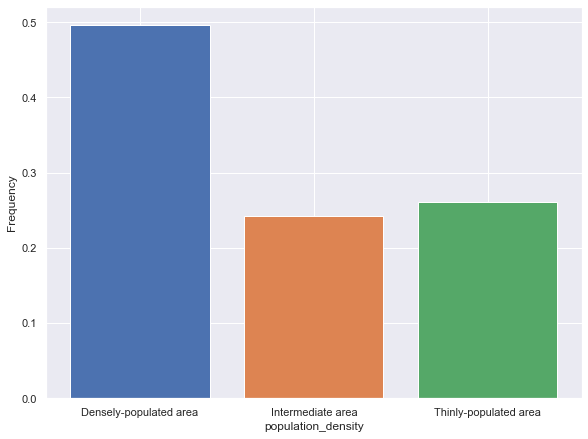

In [34]:
barplot(x='population_density', data=sociodemo)

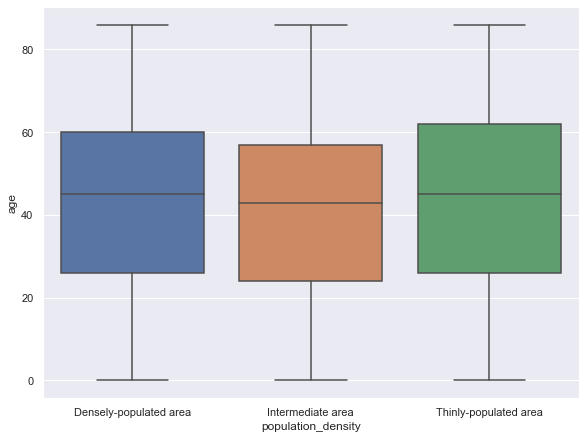

In [35]:
boxplot(x='population_density', y='age', data=sociodemo)

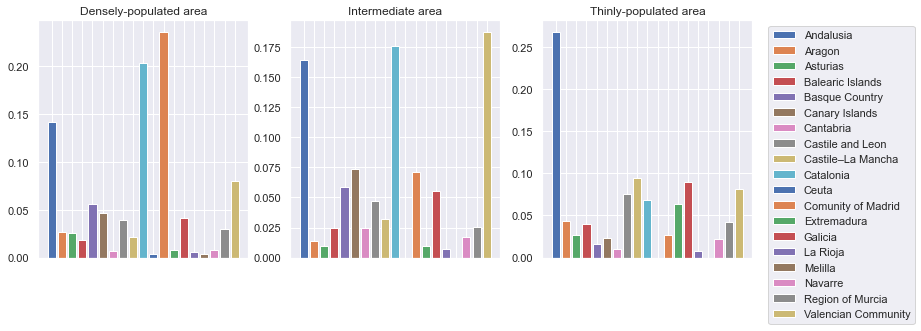

In [36]:
bardiagram(x='population_density', hue='region', data=sociodemo, legend=True)

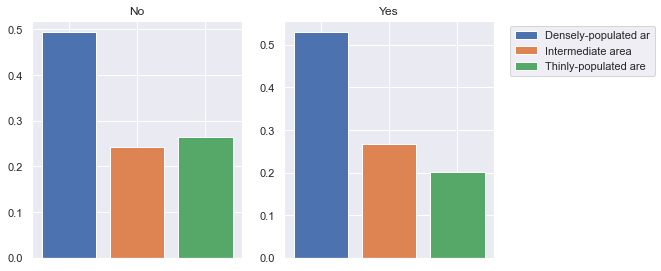

In [37]:
bardiagram(x='material_deprivation', hue='population_density', data=sociodemo, legend=True)

In [38]:
sociodemo['citizenship'] = ilc['Citizenship']

sociodemo.citizenship = sociodemo.citizenship.fillna('Missing')
sociodemo.head()

,id,weight,material_deprivation,sex,age,civil_status,consensual_union,familial_status,region,population_density,citizenship
0,101,906.15830,No,Male,70,Married,"Yes, with legal basis",No,Basque Country,Thinly-populated area,Spain
1,102,906.15830,No,Female,68,Married,"Yes, with legal basis",No,Basque Country,Thinly-populated area,Spain
2,201,1227.68869,No,Female,72,Married,"Yes, with legal basis",No,Basque Country,Thinly-populated area,Spain
3,202,1227.68869,No,Male,60,Married,"Yes, with legal basis",No,Basque Country,Thinly-populated area,Spain
4,301,2559.35987,No,Female,54,Divorced,No,Yes,Basque Country,Thinly-populated area,Spain


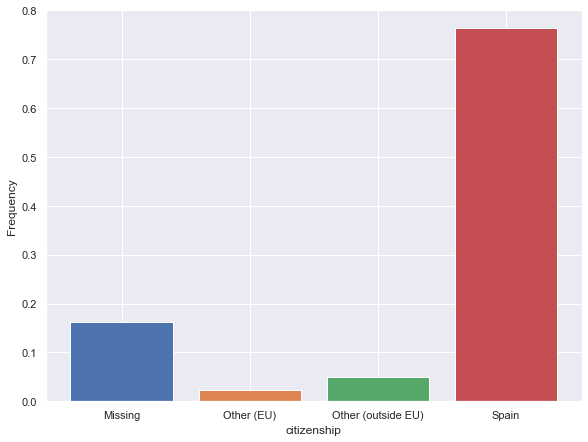

In [39]:
barplot(x='citizenship', data=sociodemo)

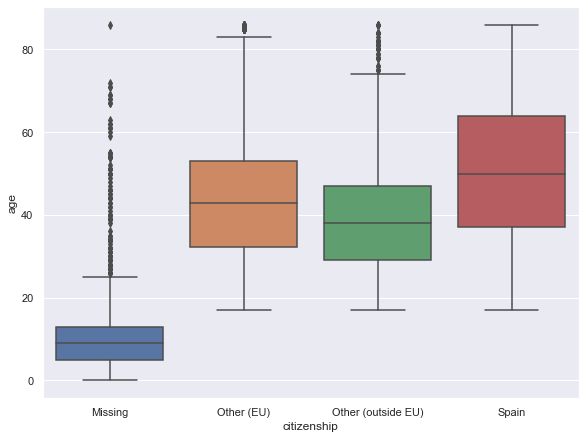

In [40]:
boxplot(x='citizenship', y='age', data=sociodemo)

In [41]:
sociodemo['head_id'] = ilc['Person 1 responsible for the accommodation']
sociodemo.head()

,id,weight,material_deprivation,sex,age,civil_status,consensual_union,familial_status,region,population_density,citizenship,head_id
0,101,906.15830,No,Male,70,Married,"Yes, with legal basis",No,Basque Country,Thinly-populated area,Spain,101
1,102,906.15830,No,Female,68,Married,"Yes, with legal basis",No,Basque Country,Thinly-populated area,Spain,101
2,201,1227.68869,No,Female,72,Married,"Yes, with legal basis",No,Basque Country,Thinly-populated area,Spain,201
3,202,1227.68869,No,Male,60,Married,"Yes, with legal basis",No,Basque Country,Thinly-populated area,Spain,201
4,301,2559.35987,No,Female,54,Divorced,No,Yes,Basque Country,Thinly-populated area,Spain,301


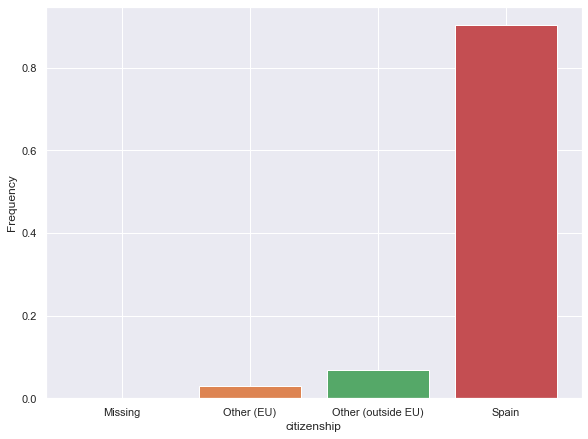

In [42]:
sociodemo.citizenship = get_parent('head_id', 'citizenship', sociodemo)

barplot(x='citizenship', data=sociodemo)

In [43]:
sociodemo['country_of_birth'] = ilc['Country of birth']

sociodemo.country_of_birth = sociodemo.country_of_birth.fillna('Missing')
sociodemo.head()

,id,weight,material_deprivation,sex,age,civil_status,consensual_union,familial_status,region,population_density,citizenship,head_id,country_of_birth
0,101,906.15830,No,Male,70,Married,"Yes, with legal basis",No,Basque Country,Thinly-populated area,Spain,101,Spain
1,102,906.15830,No,Female,68,Married,"Yes, with legal basis",No,Basque Country,Thinly-populated area,Spain,101,Spain
2,201,1227.68869,No,Female,72,Married,"Yes, with legal basis",No,Basque Country,Thinly-populated area,Spain,201,Spain
3,202,1227.68869,No,Male,60,Married,"Yes, with legal basis",No,Basque Country,Thinly-populated area,Spain,201,Spain
4,301,2559.35987,No,Female,54,Divorced,No,Yes,Basque Country,Thinly-populated area,Spain,301,Spain


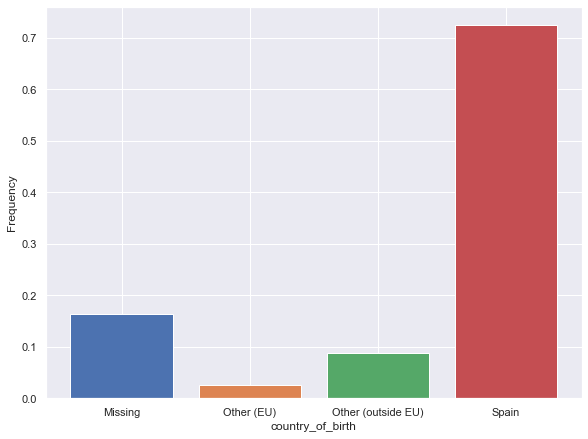

In [44]:
barplot(x='country_of_birth', data=sociodemo)

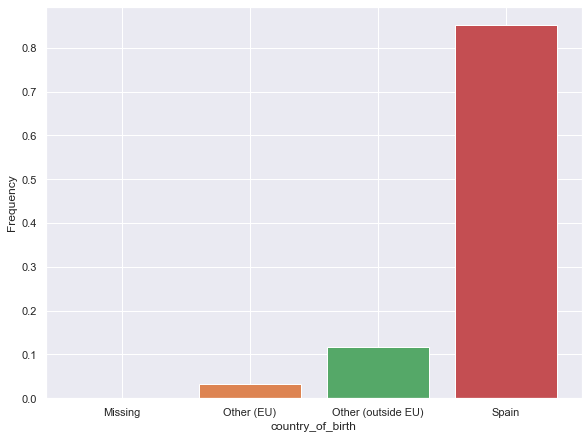

In [45]:
sociodemo.country_of_birth = get_parent('head_id', 'country_of_birth', sociodemo)

barplot(x='country_of_birth', data=sociodemo)

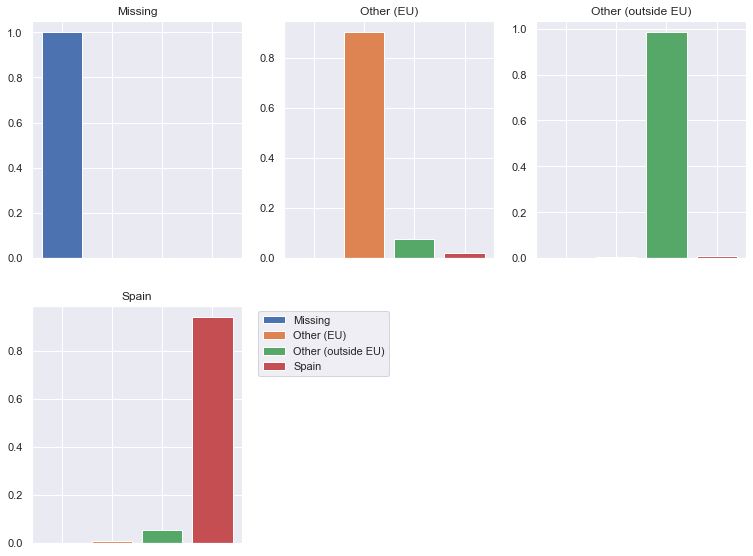

In [46]:
bardiagram(x='citizenship', hue='country_of_birth', data=sociodemo, legend=True)

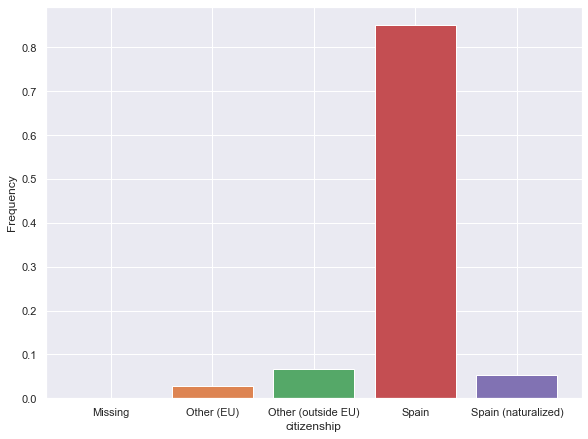

In [47]:
sociodemo['citizenship'] = sociodemo.apply(lambda row: "Spain (naturalized)" 
                                           if row['citizenship'] == 'Spain' 
                                           and row['country_of_birth'] == 'Other (outside EU)'
                                           else ("Spain (naturalized)"
                                                 if row['citizenship'] == 'Spain'
                                                 and row['country_of_birth'] == 'Other (EU)'
                                                 else row['citizenship']),
                                           axis=1)

barplot(x='citizenship', data=sociodemo)

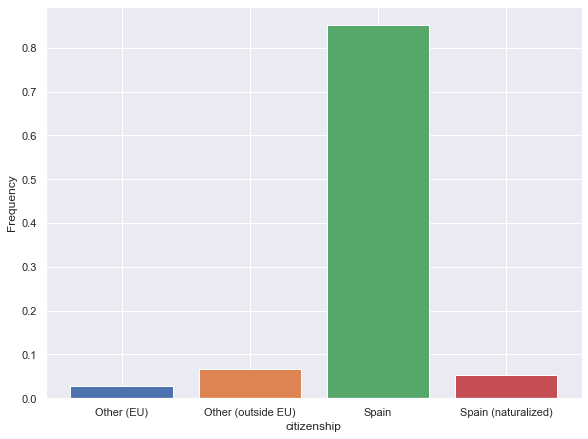

In [48]:
sociodemo['citizenship'] = sociodemo.apply(lambda row: sociodemo.citizenship.mode()[0] 
                                           if row['citizenship'] == 'Missing'
                                           else row['citizenship'],
                                           axis=1)

barplot(x='citizenship', data=sociodemo)

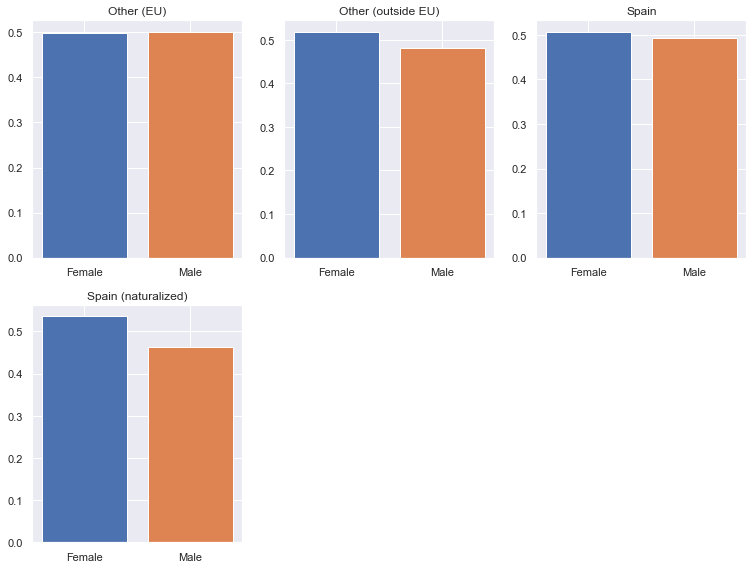

In [49]:
bardiagram(x='citizenship', hue='sex', data=sociodemo)

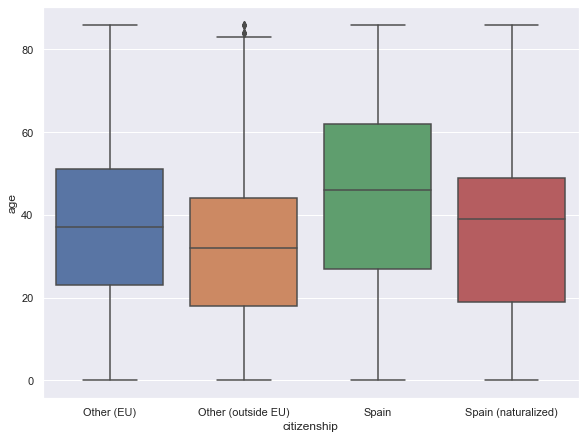

In [50]:
boxplot(x='citizenship', y='age', data=sociodemo)

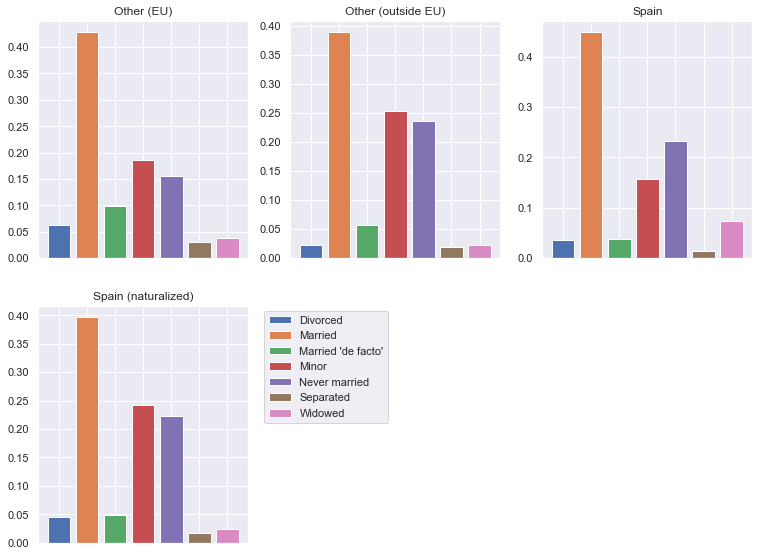

In [51]:
bardiagram(x='citizenship', hue='civil_status', data=sociodemo, legend=True)

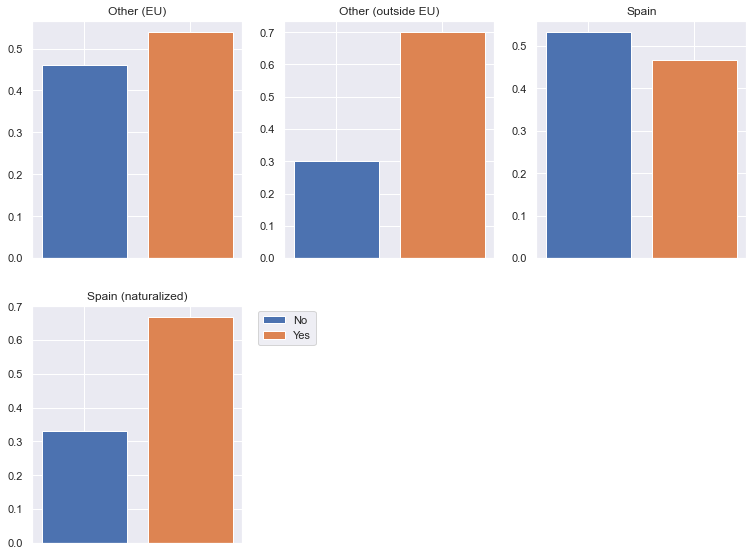

In [52]:
bardiagram(x='citizenship', hue='familial_status', data=sociodemo, legend=True)

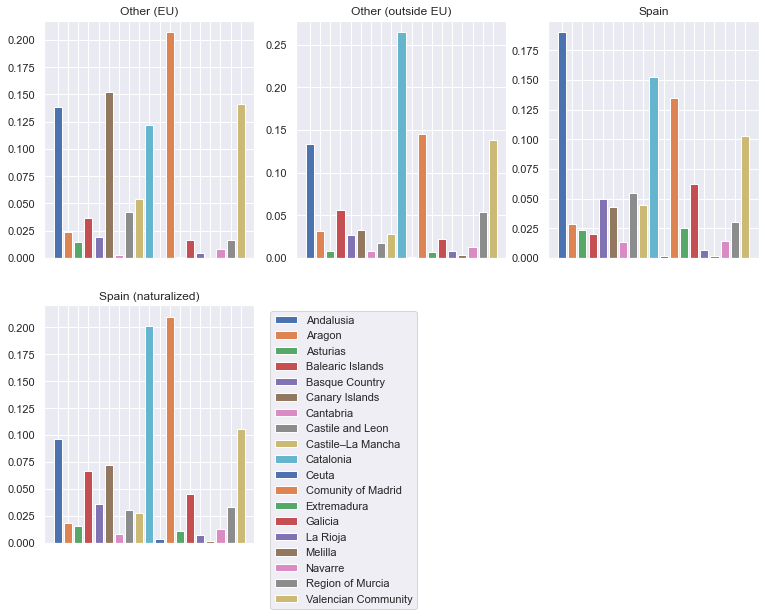

In [53]:
bardiagram(x='citizenship', hue='region', data=sociodemo, legend=True)

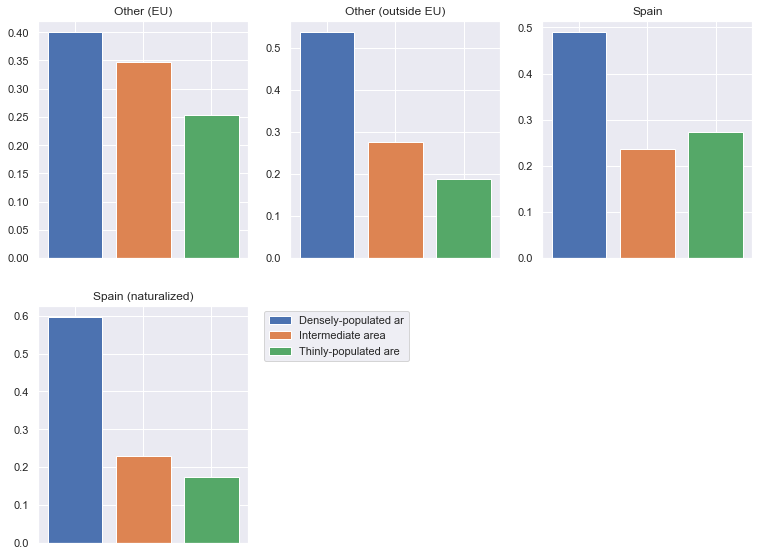

In [54]:
bardiagram(x='citizenship', hue='population_density', data=sociodemo, legend=True)

In [55]:
sociodemo['tenure_status'] = ilc['Tenure status']

sociodemo.head()

,id,weight,material_deprivation,sex,age,civil_status,consensual_union,familial_status,region,population_density,citizenship,head_id,country_of_birth,tenure_status
0,101,906.15830,No,Male,70,Married,"Yes, with legal basis",No,Basque Country,Thinly-populated area,Spain,101,Spain,Outright owner
1,102,906.15830,No,Female,68,Married,"Yes, with legal basis",No,Basque Country,Thinly-populated area,Spain,101,Spain,Outright owner
2,201,1227.68869,No,Female,72,Married,"Yes, with legal basis",No,Basque Country,Thinly-populated area,Spain,201,Spain,Outright owner
3,202,1227.68869,No,Male,60,Married,"Yes, with legal basis",No,Basque Country,Thinly-populated area,Spain,201,Spain,Outright owner
4,301,2559.35987,No,Female,54,Divorced,No,Yes,Basque Country,Thinly-populated area,Spain,301,Spain,Outright owner


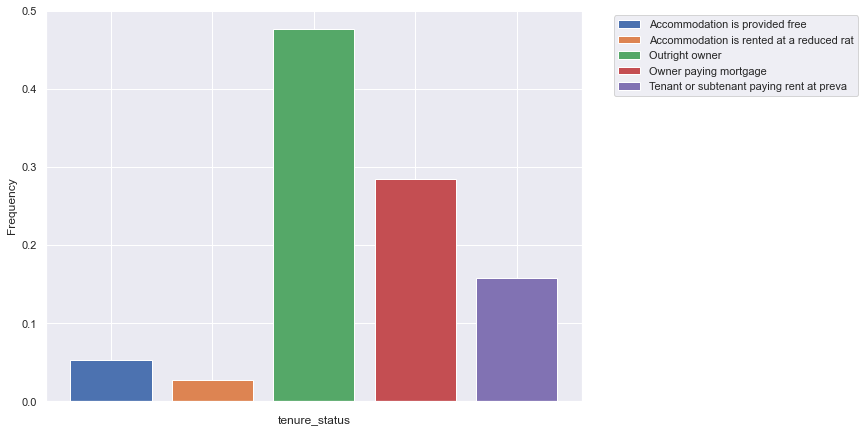

In [56]:
barplot(x='tenure_status', data=sociodemo, legend=True)

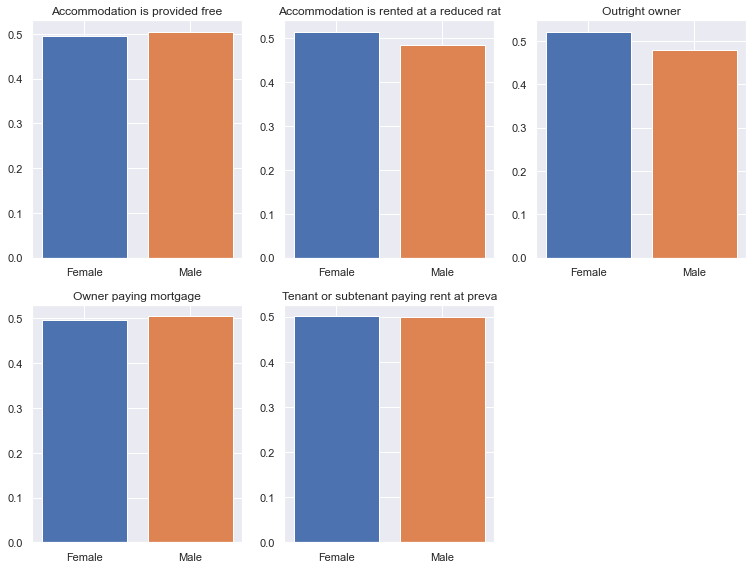

In [57]:
bardiagram(x='tenure_status', hue='sex', data=sociodemo)

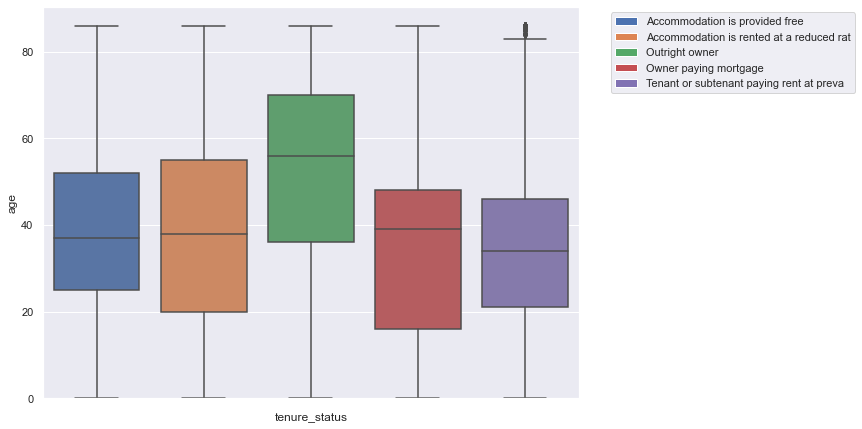

In [58]:
boxplot(x='tenure_status', y='age', data=sociodemo, legend=True)

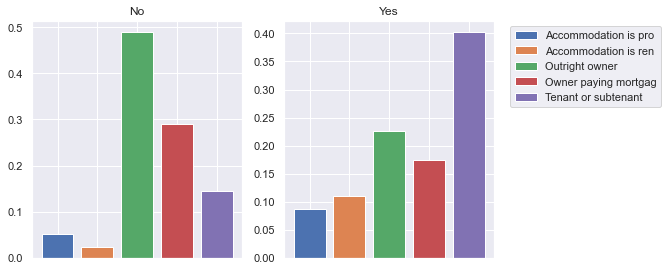

In [59]:
bardiagram(x='material_deprivation', hue='tenure_status', data=sociodemo, legend=True)

In [60]:
sociodemo = sociodemo.drop(['consensual_union', 'head_id', 'country_of_birth'], axis=1)

In [61]:
sociodemo.to_csv('sociodemo.csv')

In [37]:
for c in ilc.columns:
    print(c)

Personal ID
Personal cross-sectional weight
Year of birth
Sex
Basic activity status
Education at pre-school
Education at compulsory school
Childcare at centre-based services
Childcare at day-care centre
Childcare by a professional child-minder at child's home or at child-minder’s home
Childcare by grand-parents, other household members (outside parents), other relatives, friends or neighbours
Childrens’ cross-sectional weight for childcare
Living in household with low employement level
Living in household under risk of poverty
Marital status
Consensual Union
Country of birth
Citizenship
Current education activity
ISCED level currently attended
Year when highest level of education was attained
Highest ISCED level attained
Self-defined current economic status
Whether person has ever worked
Actively looking for a job
Available for work
Status in employment
Occupation
Number of hours usually worked per week in main job
Number of months spent at full-time work as employee
Number of months s